# LFP analysis


## Frequency Bands in Mice and Rats:
Delta (0.5-4 Hz): Associated with deep sleep.

Theta (4-12 Hz): Linked to sleep, rest, and some cognitive processes.

Alpha (8-15 Hz): Often related to relaxed wakefulness.

Beta (15-30 Hz): Associated with active thinking and alertness.

Gamma (30-100 Hz): Related to higher cognitive functions and information processing.

## Frequency Bands in Humans:
Delta (0.5-4 Hz): Similar to mice and rats, associated with deep sleep.

Theta (4-7 Hz): Also similar, linked to sleep and some cognitive processes.

Alpha (8-12 Hz): Similar, related to relaxed wakefulness.

Beta (12-30 Hz): Slightly different, associated with active thinking and alertness.

Gamma (30-100 Hz): Similar, related to higher cognitive functions and information processing.

In [1]:
import os
import spikeinterface.full as si
print(f"SpikeInterface version: {si.__version__}")
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import scipy as sc
import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline


SpikeInterface version: 0.102.0


In [2]:
base_folder  = 'D:/ephys/R002/2024-03-14'
def get_subfolders(directory):
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and any(char in f.name for char in 'out')]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and all(char not in f.name for char in 'out')]
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and f.name[-2:].isdigit()]

    return subfolders


rec_subfolders = get_subfolders(base_folder)
print(rec_subfolders)

['D:/ephys/R002/2024-03-14\\2024-03-14_21-59-42', 'D:/ephys/R002/2024-03-14\\2024-03-14_22-33-05', 'D:/ephys/R002/2024-03-14\\2024-03-14_23-28-21']


In [3]:
band_freq = np.array([[4,8],[8,15],[15,30],[30,100]])


In [4]:
# to load lfp data from NPX1.0 we have to load different stream (here =2). but NPX2 is saving all data togheter. 

recordings_list2 = []
for dir in rec_subfolders:
    recordings_list2.append( si.read_openephys(dir,stream_id='2'))
 
recordings_list2

[OpenEphysBinaryRecordingExtractor: 384 channels - 2500.0Hz - 1 segments - 3,558,656 samples 
                                    1,423.46s (23.72 minutes) - int16 dtype - 2.55 GiB,
 OpenEphysBinaryRecordingExtractor: 384 channels - 2500.0Hz - 1 segments - 1,992,646 samples 
                                    797.06s (13.28 minutes) - int16 dtype - 1.43 GiB,
 OpenEphysBinaryRecordingExtractor: 384 channels - 2500.0Hz - 1 segments - 6,212,479 samples 
                                    2,484.99s (41.42 minutes) - int16 dtype - 4.44 GiB]

In [5]:
multirecording_lfp = si.concatenate_recordings(recordings_list2)
multirecording_lfp

ConcatenateSegmentRecording: 384 channels - 2500.0Hz - 1 segments - 11,763,781 samples 
                             4,705.51s (1.31 hours) - int16 dtype - 8.41 GiB

In [26]:

DownSampl_fs = 300

lfprec0 = si.bandpass_filter(
    multirecording_lfp,
    freq_min=0.5,
    freq_max=250,

    margin_ms=1500.,
    filter_order=3,
    dtype="float32",
    add_reflect_padding=True,
)
lfprec0 = si.phase_shift(lfprec0)
bad_channel_ids, channel_labels = si.detect_bad_channels(lfprec0)
lfprec0 = si.interpolate_bad_channels(lfprec0, bad_channel_ids, sigma_um=None, p=1.3, weights=None)
lfprec = si.resample(lfprec0, resample_rate=250, margin_ms=1000)

lfprec = si.directional_derivative(lfprec, order=2, edge_order=1)
lfprec = si.average_across_direction(lfprec)

print('bad_channel_ids', bad_channel_ids)

bad_channel_ids ['LFP192']


In [7]:
def get_lfp_band(recording, fr_band,DownSampl_fs,bad_channel_ids):
    lfp_band = si.bandpass_filter(recording,freq_min=fr_band[0],freq_max=fr_band[1],margin_ms=1500.,filter_order=3,dtype="float32",add_reflect_padding=True)
    
    lfp_band = si.phase_shift(lfp_band)
    lfp_band = si.resample(lfp_band, resample_rate=DownSampl_fs, margin_ms=1000)
    
    lfp_band = si.interpolate_bad_channels(lfp_band, bad_channel_ids, sigma_um=None, p=1.3, weights=None)
    
    # lfp_band = si.directional_derivative(lfp_band, order=2, edge_order=1)
    lfp_band = si.average_across_direction(lfp_band)
    return(lfp_band)


In [8]:
brain_waves = []
for b in range(len(band_freq)):
    brain_waves.append( get_lfp_band(multirecording_lfp, band_freq[b,],DownSampl_fs,bad_channel_ids))
 

In [9]:
# Delta = brain_waves[0]
Theta = brain_waves[0]
Alpha = brain_waves[1]
Beta  = brain_waves[2]
Gamma = brain_waves[3]

In [27]:
%matplotlib widget
si.plot_traces({'Theta':brain_waves[0],'Alpha':brain_waves[1],'Beta':brain_waves[2],'Gamma':brain_waves[3], 'lfp': lfprec}, backend='ipywidgets',time_range=(1400.0,1410))

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

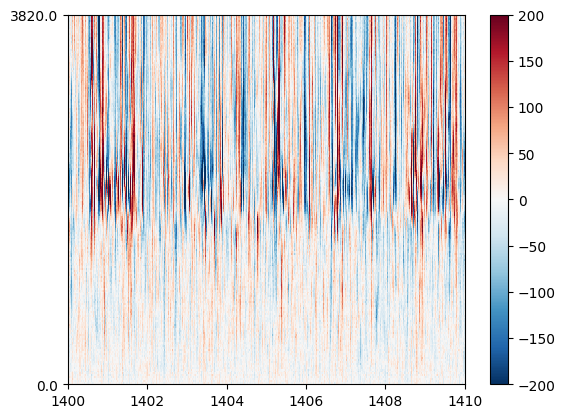

In [13]:
%matplotlib inline
si.plot_traces(Gamma, backend="matplotlib", mode="map", time_range=(1400,1410))
plt.savefig(base_folder+'/Gamma.pdf')

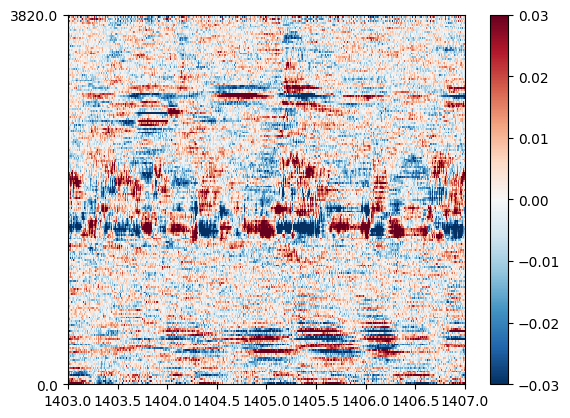

In [35]:
%matplotlib inline
si.plot_traces(lfprec, backend="matplotlib", mode="map", clim=(-0.03, 0.03), time_range=(1403,1407))
plt.savefig(base_folder+'/lfp_csd1.pdf')

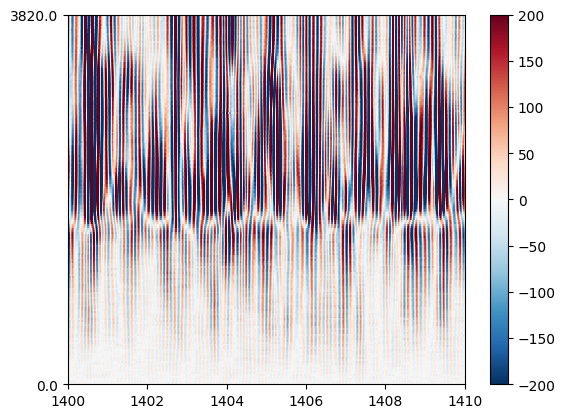

In [16]:
%matplotlib inline
si.plot_traces(Theta, backend="matplotlib", mode="map", time_range=(1400,1410))
plt.savefig(base_folder+'/Theta.pdf')

In [18]:
from scipy.signal import welch
import numpy as np

# Function to compute average power using Welch's method over 10 intervals of 1 second each
def compute_average_psd(lfp_data, fs, interval_duration=1, num_intervals=10):
    """
    Compute the average power spectral density (PSD) for each channel using Welch's method.

    Parameters:
        lfp_data (np.ndarray): LFP data of shape (n_channels, n_samples).
        fs (int): Sampling frequency.
        interval_duration (int): Duration of each interval in seconds.
        num_intervals (int): Number of intervals to average over.

    Returns:
        freqs (np.ndarray): Frequencies corresponding to the PSD.
        avg_psd (np.ndarray): Averaged PSD over the intervals, shape (n_channels, len(freqs)).
    """
    n_channels, n_samples = lfp_data.shape
    segment_length = interval_duration * fs  # Samples per interval (1 second)
    
    # Prepare to store PSDs
    psd_all_intervals = np.zeros((n_channels, fs//2 + 1))
    
    # Calculate PSD for each channel over all intervals
    for channel in range(n_channels):
        ch_data = lfp_data[channel,:]
        psds = np.zeros((num_intervals, fs//2 + 1))  # To store PSD results for each interval

        for i in range(num_intervals):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length
            
            # Calculate PSD for this channel in the current interval
            freqs, psd = welch(ch_data[start_idx:end_idx], fs, nperseg=segment_length)
            psds[i, :] = psd
        psd_chan = np.mean(psds)
        psd_all_intervals[channel, :] = psd_chan  # Store PSD for all intervals of this channel
    
    # Average PSD across intervals for each channel
    avg_psd =psd_all_intervals # Shape: (n_channels, len(freqs))
    
    # Convert to log10 scale
    # avg_psd = np.log10(avg_psd)
    return freqs, avg_psd


In [19]:

Alpha_snippet = Alpha.get_traces(start_frame=int(DownSampl_fs*1400), end_frame=int(DownSampl_fs*1410))

freqs, avg_psd = compute_average_psd(Alpha_snippet.T, DownSampl_fs)

# Output the results dimensions to verify
freqs.shape, avg_psd.shape



((151,), (192, 151))

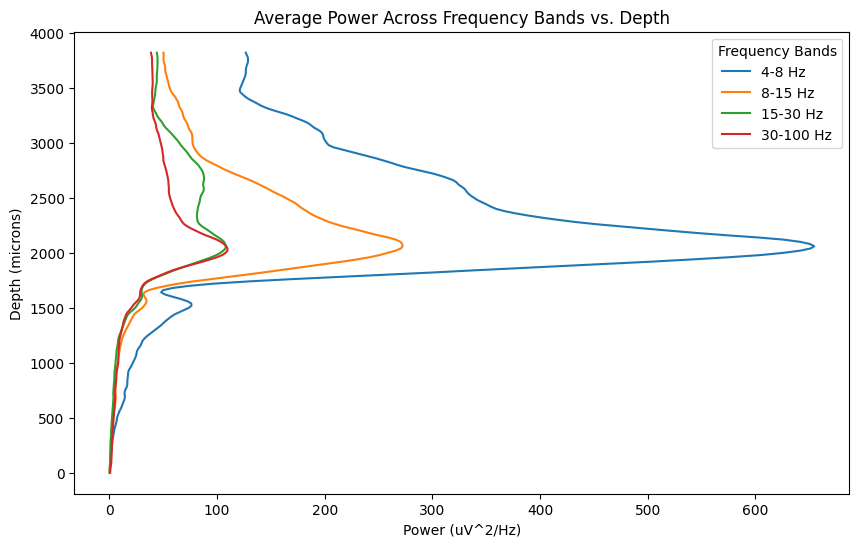

In [22]:

electrode_spacing = 20e-6  # Electrode spacing in meters (20 microns)

depths = np.arange(192) * electrode_spacing  # Depth in meters for each electrode
sigma = 1 # Standard deviation for Gaussian kernel 
plt.figure(figsize=(10, 6))

for i, (fmin, fmax) in enumerate(band_freq):
    # Compute PSD within the specific frequency band
    lfp_data = brain_waves[i].get_traces(start_frame=int(DownSampl_fs*1400), end_frame=int(DownSampl_fs*1410))
    lfp_data = lfp_data.T
    freqs, avg_psd = compute_average_psd(lfp_data, DownSampl_fs,interval_duration=1, num_intervals=10)
    
    # Average power within the band for each channel
    mean_power_band = np.mean(avg_psd[:,int(np.floor(fmin)):int(fmax+1)], axis=1)  # Average power over the band frequencies
    mean_power_band = sc.ndimage.gaussian_filter(mean_power_band, sigma=sigma)


    # Plot the power against depth
    plt.plot(mean_power_band, depths * 1e6, label=f"{fmin}-{fmax} Hz")  # Convert depth to microns for plotting

# Labeling the plot
plt.xlabel("Power (uV^2/Hz)")
plt.ylabel("Depth (microns)")
plt.title("Average Power Across Frequency Bands vs. Depth")
# plt.gca().invert_yaxis()  # Depth increases downward
plt.legend(title="Frequency Bands")


plt.savefig(base_folder+'/psd_welch.pdf')
plt.show()

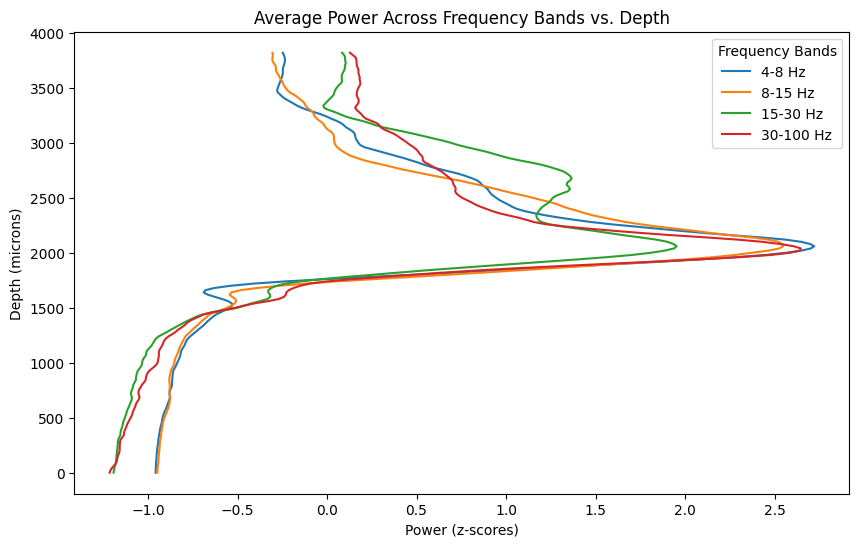

In [25]:
from scipy.stats import zscore
electrode_spacing = 20e-6  # Electrode spacing in meters (20 microns)

depths = np.arange(192) * electrode_spacing  # Depth in meters for each electrode
sigma = 1 # Standard deviation for Gaussian kernel 
plt.figure(figsize=(10, 6))

for i, (fmin, fmax) in enumerate(band_freq):
    # Compute PSD within the specific frequency band
    lfp_data = brain_waves[i].get_traces(start_frame=int(DownSampl_fs*1400), end_frame=int(DownSampl_fs*1410))
    lfp_data = lfp_data.T
    freqs, avg_psd = compute_average_psd(lfp_data, DownSampl_fs,interval_duration=1, num_intervals=10)
    
    # Average power within the band for each channel
    mean_power_band = np.mean(avg_psd[:,int(np.floor(fmin)):int(fmax+1)], axis=1)  # Average power over the band frequencies
    mean_power_band = sc.ndimage.gaussian_filter(mean_power_band, sigma=sigma)
    # Calculate the z-scores 
    mean_power_band = zscore(mean_power_band)


    # Plot the power against depth
    plt.plot(mean_power_band, depths * 1e6, label=f"{fmin}-{fmax} Hz")  # Convert depth to microns for plotting

# Labeling the plot
plt.xlabel("Power (z-scores)")
plt.ylabel("Depth (microns)")
plt.title("Average Power Across Frequency Bands vs. Depth")
# plt.gca().invert_yaxis()  # Depth increases downward
plt.legend(title="Frequency Bands")


plt.savefig(base_folder+'/psd_welch_z-scored.pdf')
plt.show()

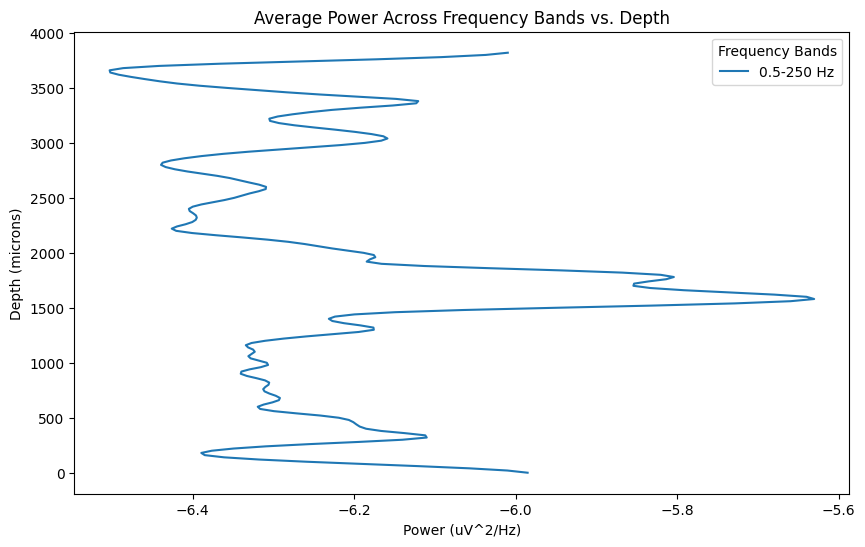

In [42]:

electrode_spacing = 20e-6  # Electrode spacing in meters (20 microns)
fmin=0.5
fmax=250
depths = np.arange(192) * electrode_spacing  # Depth in meters for each electrode
sigma = 2 # Standard deviation for Gaussian kernel 
plt.figure(figsize=(10, 6))


# Compute PSD within the specific frequency band
lfp_data = lfprec.get_traces(start_frame=int(DownSampl_fs*1400), end_frame=int(DownSampl_fs*1410))
lfp_data = lfp_data.T
freqs, avg_psd = compute_average_psd(lfp_data, DownSampl_fs,interval_duration=1, num_intervals=10)

# Average power within the band for each channel
mean_power_band = np.mean(avg_psd[:,int(np.floor(fmin)):int(fmax+1)], axis=1)  # Average power over the band frequencies
mean_power_band = sc.ndimage.gaussian_filter(mean_power_band, sigma=sigma)
mean_power_band = np.log10(mean_power_band)

# Plot the power against depth
plt.plot(mean_power_band, depths * 1e6, label=f"{fmin}-{fmax} Hz")  # Convert depth to microns for plotting

# Labeling the plot
plt.xlabel("Power (uV^2/Hz)")
plt.ylabel("Depth (microns)")
plt.title("Average Power Across Frequency Bands vs. Depth")
# plt.gca().invert_yaxis()  # Depth increases downward
plt.legend(title="Frequency Bands")


plt.savefig(base_folder+'/psd_of CSD welch.pdf')
plt.show()

In [23]:

def compute_psd_fft(lfp_data, fs, interval_duration=1, num_intervals=10):
 
    n_channels, n_samples = lfp_data.shape
    segment_length = interval_duration * fs  # Samples per interval (1 second)
    
    # Prepare to store PSDs
    psd_all_intervals = []
    

    # Loop through each 1-second interval
    for i in range(num_intervals):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        
        # Calculate PSD for each channel for this interval
        psds = []
        for channel in range(n_channels):
            X = lfp_data[channel, start_idx:end_idx]
            Y = np.fft.fft(X)
            L = len(Y)
            P2 = np.abs(Y / L)**2    # Compute the two-sided power spectral density
            
            P1 = P2[:L//2 + 1]       # Take the first half to get the single-sided PSD
            P1[1:-1] = 2 * P1[1:-1]  # Double all frequencies except DC and Nyquist
            P1=P1[1:]

            psds.append(P1)
                 
        psd_all_intervals.append(np.array(psds))
    
    # Generate frequency bins for the single-sided spectrum
    freqs = np.fft.fftfreq(L, d=1/fs)[:L//2 + 1]
    # Convert to a numpy array for averaging
    psd_all_intervals = np.array(psd_all_intervals)  # Shape: (num_intervals, n_channels, len(freqs))
    
    # Average PSD across intervals
    avg_psd = np.mean(psd_all_intervals, axis=0)  # Shape: (n_channels, len(freqs))
    print(psd_all_intervals.shape)
     # Convert to log10 scale
    # avg_psd = np.log10(avg_psd)
    return freqs, avg_psd


(10, 192, 150)
(10, 192, 150)
(10, 192, 150)
(10, 192, 150)


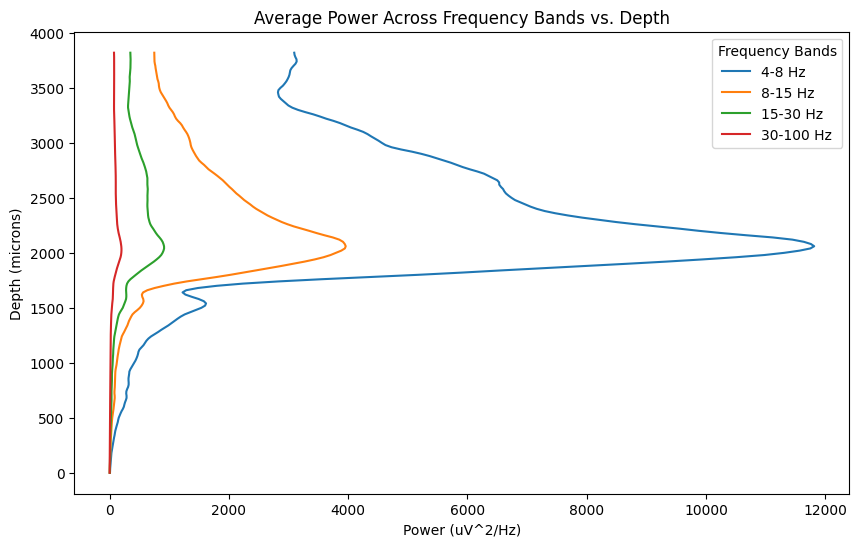

In [24]:

electrode_spacing = 20e-6  # Electrode spacing in meters (20 microns)

depths = np.arange(192) * electrode_spacing  # Depth in meters for each electrode
sigma = 1 # Standard deviation for Gaussian kernel 
plt.figure(figsize=(10, 6))

for i, (fmin, fmax) in enumerate(band_freq):
    # Compute PSD within the specific frequency band
    lfp_data = brain_waves[i].get_traces(start_frame=int(DownSampl_fs*1400), end_frame=int(DownSampl_fs*1410))
    lfp_data = lfp_data.T
    freqs, avg_psd = compute_psd_fft(lfp_data, DownSampl_fs)
    
    # Average power within the band for each channel
    mean_power_band = np.mean(avg_psd[:,int(np.floor(fmin)):int(fmax+1)], axis=1)  # Average power over the band frequencies
    mean_power_band = sc.ndimage.gaussian_filter(mean_power_band, sigma=sigma)


    # Plot the power against depth
    plt.plot(mean_power_band, depths * 1e6, label=f"{fmin}-{fmax} Hz")  # Convert depth to microns for plotting

# Labeling the plot
plt.xlabel("Power (uV^2/Hz)")
plt.ylabel("Depth (microns)")
plt.title("Average Power Across Frequency Bands vs. Depth")
# plt.gca().invert_yaxis()  # Depth increases downward
plt.legend(title="Frequency Bands")


plt.savefig(base_folder+'/psd.pdf')
plt.show()